In [13]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [14]:
class Particle:

    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):

        self.dt = t[1] - t[0]


        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0

        self.m = m
        self.radius = radius
        self.Id = Id


        self.p = self.m*self.v

        self.f = self.m*self.a

        self.l = np.cross(self.r, self.p)

        # Historial

        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)

        self.F = np.zeros_like(self.R)

        self.P = np.zeros_like(self.R)

        self.L = np.zeros_like(self.R)


        # Fisica
        
        self.K = 20
        
        #self.sigma = 1.5*self.radius

        #self.epsilon = 1500

        self.VEk = np.zeros(len(t))
        self.Ep = 0.
        self.VEp = np.zeros(len(t))

    def Evolution(self,i):


        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetMomentum(i)
        self.SetAngularMomentum(i)
        self.a = self.f/self.m

        # Euler
       # self.r += self.dt*self.v
       # self.v += self.dt*self.a

        self.SetPotentialEnergy(i)

        # Euler-Cromer
        self.v += self.dt*self.a
        self.r += self.dt*self.v


    def CalculateForce(self,p):

        d = np.linalg.norm(self.r - p.r)

        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            self.Ep += 0.25*self.K *compresion**4
        # Falta implementar energía potencial
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
        self.Ep = 0.

    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r

    def SetVelocity(self,i):
        self.V[i] = self.v
        self.VEk[i] = 0.5*self.m*np.dot(self.v,self.v)

    def SetMomentum(self,i):
        self.p = self.m*self.v
        self.P[i] = self.p

    def SetAngularMomentum (self,i):
        self.l = np.cross(self.r, self.p)
        self.L[i] = self.l

    def SetPotentialEnergy(self,i):
        self.VEp[i] = self.Ep

    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]

    def GetVelocity(self,scale=1):
        return self.V[::scale]

    def GetMomentum(self,scale=1):
        return self.P[::scale]

    def GetKineticEnergy(self,scale=1):
        return self.VEk[::scale]

    def GetPotentialEnergy(self,scale=1):
        return self.VEp[::scale]

    def GetAngularMomentum(self,scale=1):
        return self.L[::scale]

    # Debes agregar las paredes en este punto

In [15]:
def GetParticles(N,t):
    Particles = []
    p0=0
    for i in range(N):
        valores_posibles = [-1, 1]
        xa = np.random.random()*20*np.random.choice(valores_posibles)
        ya = np.random.random()*20*np.random.choice(valores_posibles)
        r0 = np.array([xa,ya])
        vxa = np.random.random()*5*np.random.choice(valores_posibles)
        vya = np.random.random()*5*np.random.choice(valores_posibles)
        v0 = np.array([vxa,vya])
        a0 = np.array([0.,0.])
        p0 = Particle(r0,v0,a0,t,m=1,radius=2,Id=i)
        Particles.append(p0)
        p=0
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    return Particles

In [16]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [17]:
def RunSimulation(t,Particles):

    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):

        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j])

        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            # Aca debes agregar la interaccion con la pared


    return Particles

In [18]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 10000/10000 [00:48<00:00, 204.56 Steps/s]


In [19]:
# Bajamos dimensión de la simulacion
scale = 50
t1 = t[::scale]

<IPython.core.display.Javascript object>


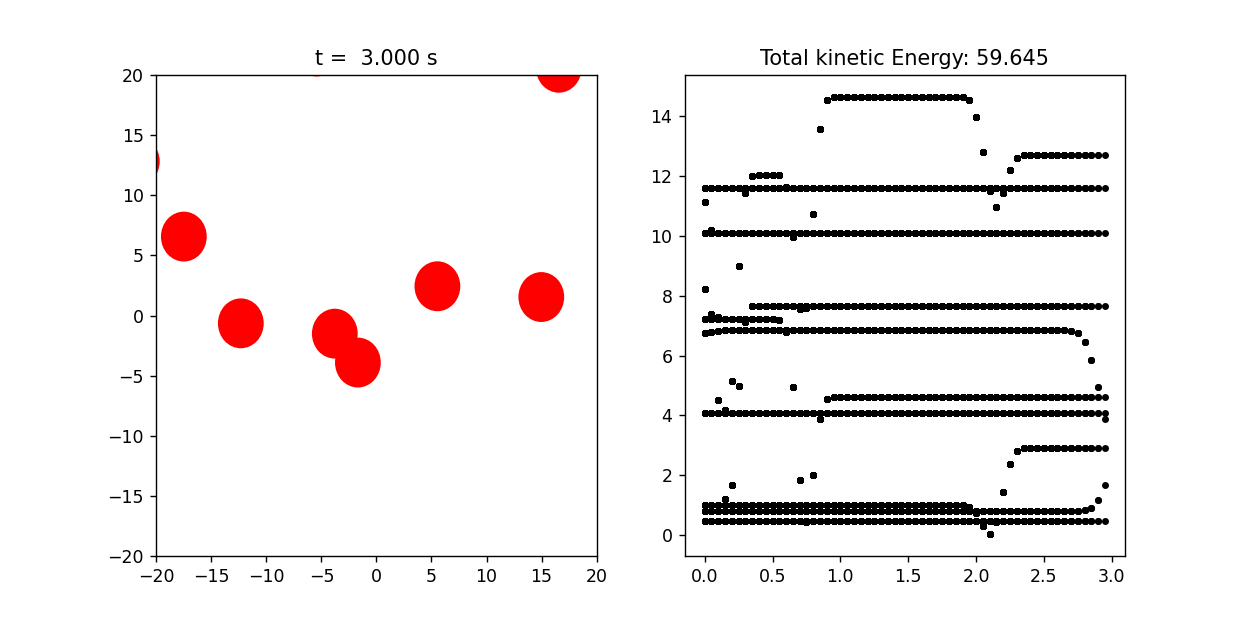

In [20]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)

def init():

    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)

def Update(i):

    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))


    # Queremos calcular la energía total de cinética
    KE = 0. # Kinetic energy

    for j, p in enumerate(Particles):

        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]

        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]

        circle = plt.Circle( (x,y), p.radius, color='r', fill=True )
        ax.add_patch(circle)

       # ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)

        KE += p.GetKineticEnergy(scale)[i]

        ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KE))
        ax1.scatter(t1[:i], p.GetKineticEnergy(scale)[:i],color='k',marker='.')

Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [21]:
MomentumT = Particles[0].GetMomentum(scale)

EnergyT = Particles[0].GetKineticEnergy(scale)

EnergyP = Particles[0].GetPotentialEnergy(scale)

AngularMomentum = Particles[0].GetAngularMomentum(scale)

EnergyP *= 0.5

In [22]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))
    EnergyT = np.add(EnergyT,Particles[i].GetKineticEnergy(scale))
    EnergyP = np.add(EnergyP,Particles[i].GetPotentialEnergy(scale))
    AngularMomentum = np.add(AngularMomentum,Particles[i].GetAngularMomentum(scale))

<IPython.core.display.Javascript object>


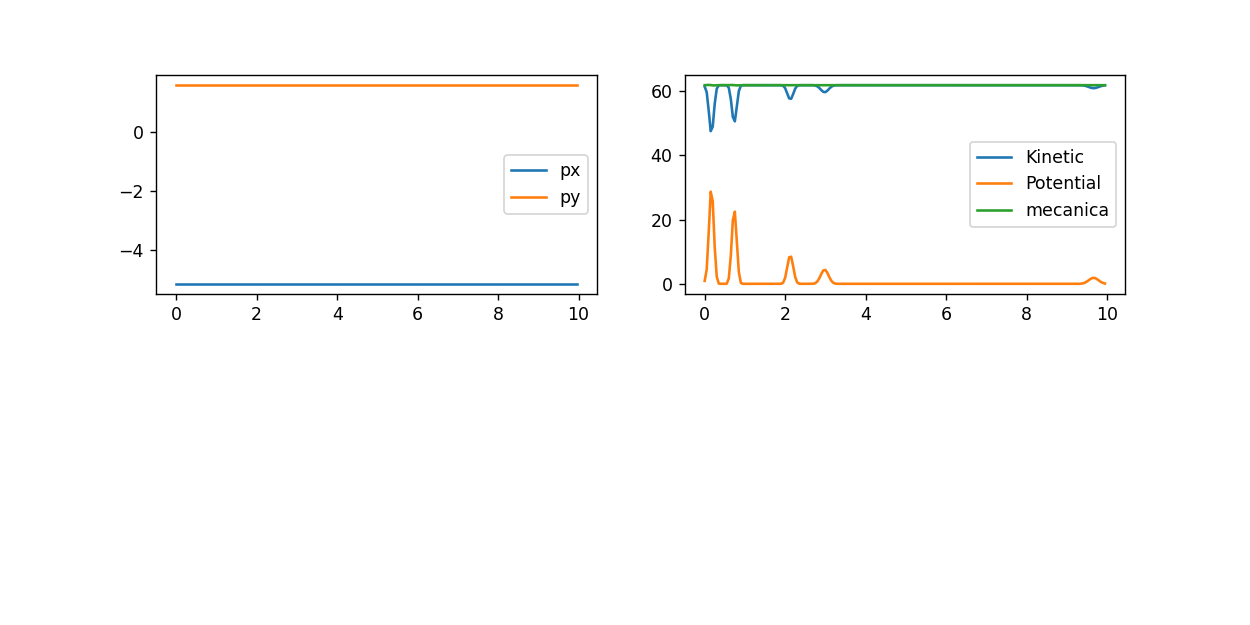

In [23]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(221)
ax4 = fig3.add_subplot(222)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax4.plot(t1,EnergyT,label='Kinetic')
ax4.plot(t1,EnergyP,label='Potential')
ax4.plot(t1,EnergyT+0.5*EnergyP,label='mecanica')
ax3.legend()
ax4.legend()

<IPython.core.display.Javascript object>


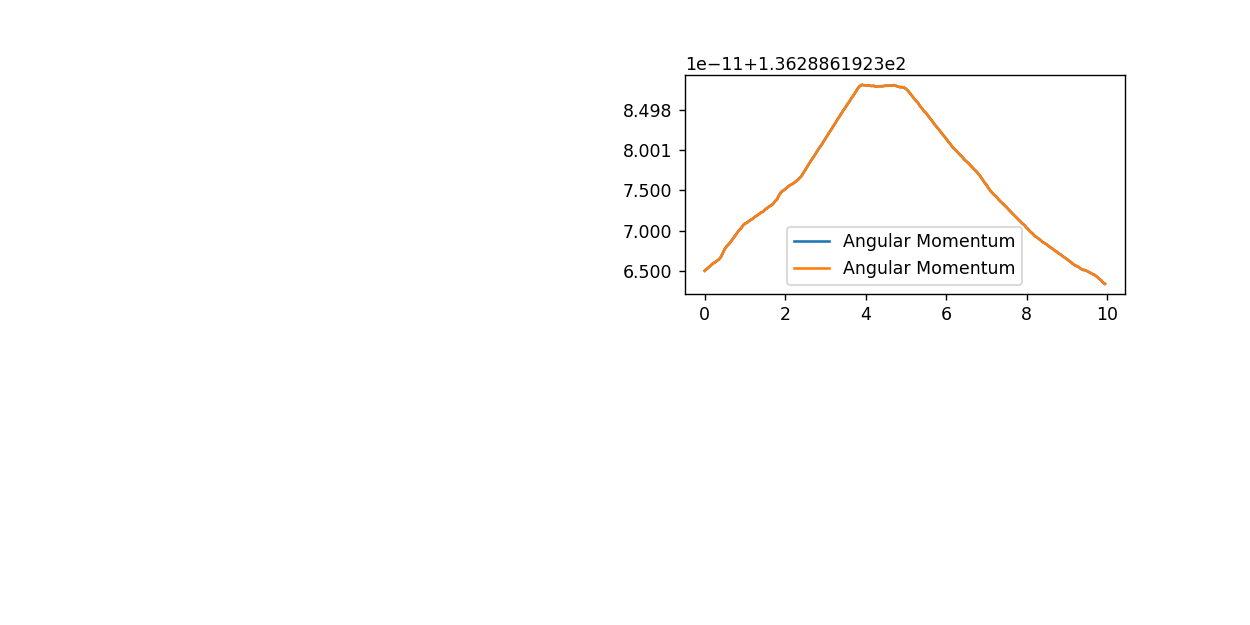

In [24]:
fig4 = plt.figure(figsize=(10,5))
ax5 = fig4.add_subplot(222)
ax5.plot(t1,AngularMomentum,label='Angular Momentum')
ax5.legend()